## Packages Required

In [293]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D 

import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# SVI Parameterisation

### SVI Class - Deprecated

### SVI Functions - Used in fitting IV surface

In [356]:
def SVI_raw(volData, a, b, m, rho, sig):

        daysExp = volData[:,0]
        strike = volData[:,1]
        totalVol = a + b * (
            rho * (strike - m) + np.sqrt((strike - m) ** 2 + sig **2))
        impliedVol = np.sqrt(totalVol / daysExp)
        return impliedVol
    
def SVI_JW(volData, a, b, m, rho, sig):
        daysExp = volData[0,:]
        strike = volData[1,:]
        t = daysExp
        
        # SVI Jump-Wings
        wt = (a + b * ( - rho * m + np.sqrt(m ** 2 + sig ** 2)))
        vt = wt / (t)
        phit = (1 / np.sqrt(wt)) * b / 2 * ( - m / np.sqrt(m ** 2 + sig ** 2) + rho)
        pt = 1 / np.sqrt(wt) * b * (1 - rho)
        ct = 1 / np.sqrt(wt) * b * ( 1+ rho)
        vTilde = (a + b * sig * np.sqrt(1 - rho ** 2)) / (t)
        
        # Parameterisation
        beta = rho - 2 * phit * np.sqrt(wt) / b
        alpha = np.sign(beta) * np.sqrt(1/(beta ** 2) - 1)
        
        bNew = np.sqrt(wt) / 2 * (ct + pt)
        rhoNew = 1 - pt * np.sqrt(wt)/b
        mNew = ((vt - vTilde) * t)/(b *(
            - rho + np.sign(alpha) * np.sqrt(1 + alpha ** 2) - alpha * np.sqrt(1 - rho ** 2)))
        aNew = vTilde * t - b * sig * np.sqrt(1 - rho)        
        if m == 0:
            sigNew = (vt * t - a)/b
        else:
            sigNew = alpha * m
            
        impliedVol = SVI_raw(volData = volData, a = aNew, b = bNew, m = mNew, rho = rhoNew, sig = sigNew)
        
        return impliedVol

## Fitting Neural Network via Neural Networks

In [294]:
class IV_Surface_Dataloader():
    def __init__(self, X, y, scale_data = True):
        if scale_data:
            X = StandardScaler().fit_transform(X)
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [335]:
class Surface(nn.Module):
    def __init__(self, hiddenNodes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, hiddenNodes),
            nn.ReLU(),
            nn.Linear(hiddenNodes, hiddenNodes),
            nn.ReLU(),
            nn.Linear(hiddenNodes, hiddenNodes),
            nn.ReLU(),
            nn.Linear(hiddenNodes, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

In [336]:
[X, y] = [dateData.filter(['moneyness', 'daysExp']).values,
          dateData.filter(['IV']).values]

torchTrainingSet = IV_Surface_Dataloader(X, y)
trainLoader = torch.utils.data.DataLoader(torchTrainingSet, batch_size = allData.shape[0], shuffle = True, num_workers = 0)

In [343]:
iv_model = Surface(80)
epochs = 1000
opt = torch.optim.Adam(iv_model.parameters(), lr = 1e-4)
loss_func = nn.MSELoss()
progress = []

for epoch in range(0, epochs):
    
    for i, data in enumerate(trainLoader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        opt.zero_grad()
        outputs = iv_model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        opt.step()
        progress.append(loss.detach().numpy())
        
print('Training finished')

Training finished


<IPython.core.display.Javascript object>


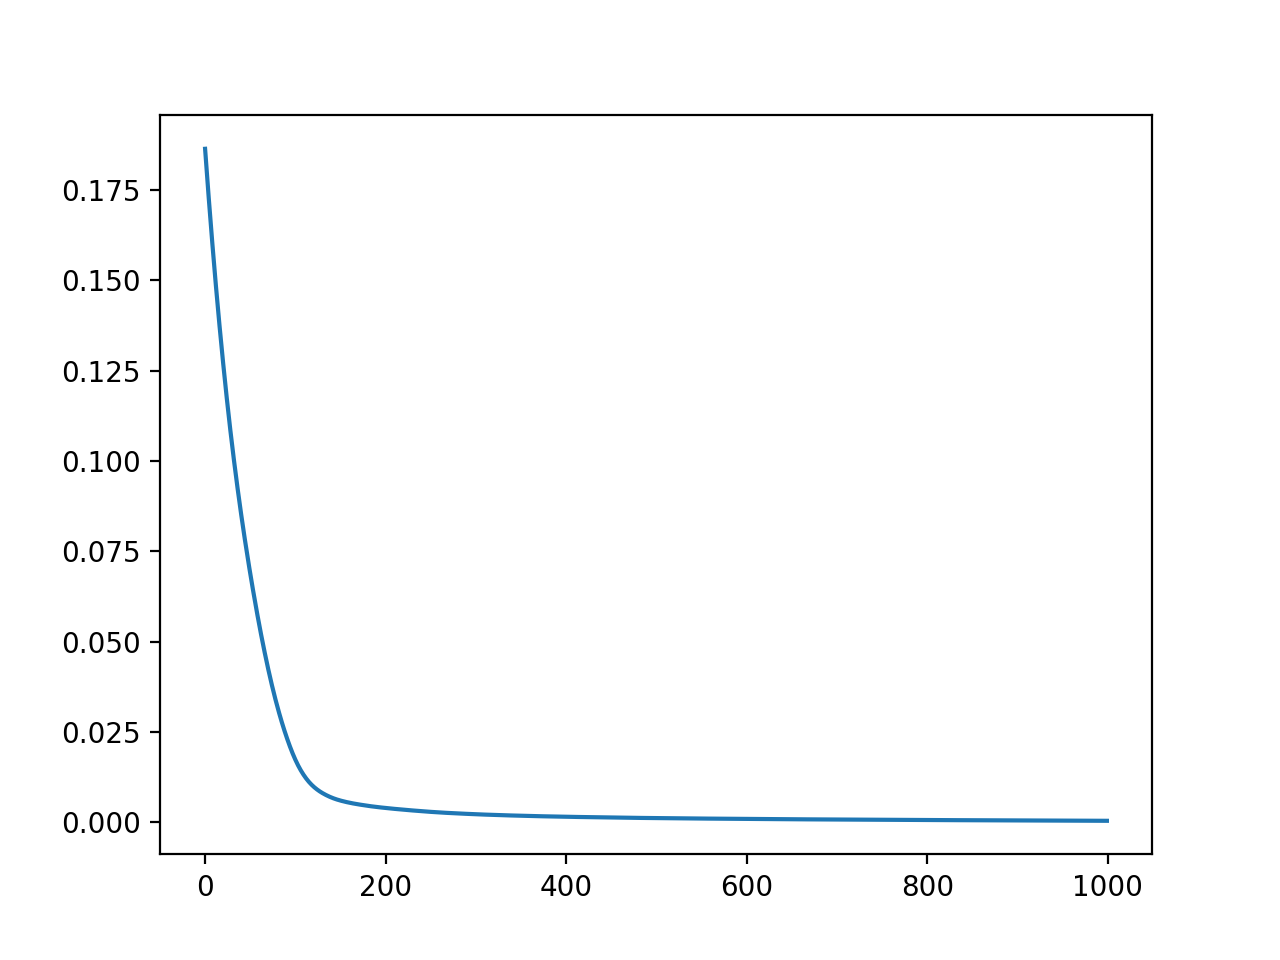

In [344]:
fig = plt.figure('Progress')
plt.plot(range(len(progress)),progress)

In [345]:
iv_model.eval()
np.stack([iv_model(inputs).detach().numpy()[:,0], yData])

array([[0.60526288, 0.1632572 , 0.64835286, ..., 0.65314353, 0.49765652,
        0.23667301],
       [1.12563   , 1.091083  , 1.056703  , ..., 0.309293  , 0.353767  ,
        0.396855  ]])

Not so good

## LM Fit

In [357]:
import lmfit

xData = np.array(allData.filter(['daysExp', 'moneyness']).loc['2015-01-02'])
yData = np.array(allData.filter(['IV']).loc['2015-01-02'])

sviModel = lmfit.Model(SVI_raw)

pars = lmfit.Parameters()
pars.add('b', value = 0.5, min = 1e-10, max = 10, vary = True)
pars.add('m', value = 0.5, max = 10, vary = True)
pars.add('rho', value = 0.5, min = -1 + 1e-10, max = 1 - 1e-10, vary = True)
pars.add('sig', value = 0.5, min = 1e-10, max = 10, vary = True)
pars.add('delta', value = 0.25, min = 0, vary = True)
pars.add('a', expr = 'delta - b * sig * sqrt(1 - rho**2)')

result = sviModel.fit(yData, pars, volData = xData)

In [363]:
b, m, rho, sig, a = list(result.best_values.values())
print(result.best_values.values())
pd.DataFrame(np.stack([SVI_raw(xData, a, b, m, rho, sig).T, yData[:,0]]))

dict_values([0.41414437035327123, -0.5337187861952017, 0.31335785161341967, 2.042130939321656e-06, 1.3380822926204952])


,0,1,2,3,4,5,6,7,8,9,...,2143,2144,2145,2146,2147,2148,2149,2150,2151,2152
0,0.36136,0.361969,0.362577,0.363063,0.363184,0.363548,0.363790,0.364032,0.364274,0.364395,...,0.122240,0.122424,0.122607,0.122790,0.122973,0.123156,0.123338,0.123702,0.124065,0.124426
1,1.12563,1.091083,1.056703,1.024873,1.016984,1.004138,0.988457,0.972879,0.957401,0.949699,...,0.134416,0.129127,0.124133,0.120106,0.116939,0.114040,0.112622,0.111040,0.110413,0.113254


In [362]:
SVI_raw(xData, a, b, m, rho, sig).shape

(2153,)

It fits but not too well.

## Fitting the IV Curve

We now fit the IV curve to the above SVI parameterisations. To do this we will adopt a least-squares approach, subject to constraints on the values of the parameters $a, b, m,$ $\rho$ and $\sigma$ as determined in the Galerkin paper.

In [4]:
priceData = np.load('joinData.pkl', allow_pickle = True)

In [265]:
allData = priceData.loc['2015-01-01':'2017-12-31']
allData = allData[(allData.moneyness > 0.6) & (allData.moneyness < 1.2)]
numDates = allData.index.unique().size


In [269]:
SVIparameters = np.zeros((numDates, 5))
initVal = [1,1,1,0.99,1]
bnds = opt.Bounds(np.array([-np.inf, 0.0001, -np.inf, -0.9999, 0.0001]),
              np.array([np.inf, np.inf, np.inf, 0.9999, np.inf]),
              keep_feasible = True)

for i in range(numDates):
    dateData = allData.loc[allData.index.unique()[i]]
    dateData = dateData[dateData.daysExp.isin(dateData.daysExp.unique()[0:5])]

    yData = dateData.filter(['IV'])
    yData = np.array(yData).T[0]

    xData = dateData.filter(['daysExp', 'moneyness'])
    xData = np.array(xData).T

    def constraint(x):
                return x[0] + x[1] * x[4] * np.sqrt(1 - x[3] **2) - 1e-8
    
    cons = {'type':'ineq', 'fun': lambda x: constraint(x)}    
        
    ## Least Squares Minimisation
    def funcToMin(x):
        return sum((SVI_raw(xData, x[0], x[1], x[2], x[3], x[4]) - yData)**2)
    

    
    fittedValues = opt.minimize(funcToMin,
                                initVal,
                                method = 'SLSQP',
                                constraints = cons,
                                bounds = bnds,
                                options={'maxiter':1e9})
    SVIparameters[i,:] = fittedValues.x

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clippin

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clippin

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: inval

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clippin

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/o

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clippin

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clippin

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clippin

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clippin

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/o

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clippin

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clippin

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysEx

Here we note the warnings, but also realise that the optimiser disregards invalid values which should 

In [275]:
dateData = allData.loc[allData.index.unique()[0]]
dateData = dateData[dateData.daysExp.isin(dateData.daysExp.unique()[0:5])]

yData = dateData.filter(['IV'])
yData = np.array(yData).T[0]

xData = dateData.filter(['daysExp', 'moneyness'])
xData = np.array(xData).T

## Fit Check
Here we test the fit of the SVI on a slice of the IV surface on a certain day in the training data.

In [276]:
# Constraints


bnds = ((None, None), (0.0001, None), (None, None), (-0.999, 0.999), (0.0001, None))

#linConstraint = opt.LinearConstraint(np.eye(5),[-np.inf, 0, -np.inf, -0.9999, 0.00001],
                               #      [np.inf, np.inf, np.inf, 0.9999, np.inf])

def constraint(x):
            return x[0] + x[1] * x[4] * np.sqrt(1 - x[3] **2)
    
cons = {'type':'ineq', 'fun': lambda x: constraint(x)}    
## Initial Values
initVal = [1,1,1,0.99,1]
        
## Least Squares Minimisation
funcToMin = lambda x: sum((SVI_raw(xData, x[0], x[1], x[2], x[3], x[4]) - yData)**2)
fittedValues = opt.minimize(funcToMin, initVal, constraints = cons, bounds = bnds,
                            method = 'SLSQP', options={'maxiter':1e8})


/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)


Now that we have parameterised the SVI for this date, we will show the fit of the curve for a single days to maturity.

In [283]:
testSet = dateData[dateData['daysExp'] == dateData.daysExp.unique()[0]]

In [284]:
[low, high] = [np.min(testSet.moneyness), np.max(testSet.moneyness)]
strikeAxis = np.linspace(low, high, 1000).T
timeValue = np.ones(1000) * dateData.daysExp.unique()[0]
xDataTest = np.stack([timeValue, strikeAxis])
[a, b, m, rho, sig] = fittedValues.x
fittedCurve = SVI_raw(xDataTest, a, b, m, rho, sig) 

<IPython.core.display.Javascript object>


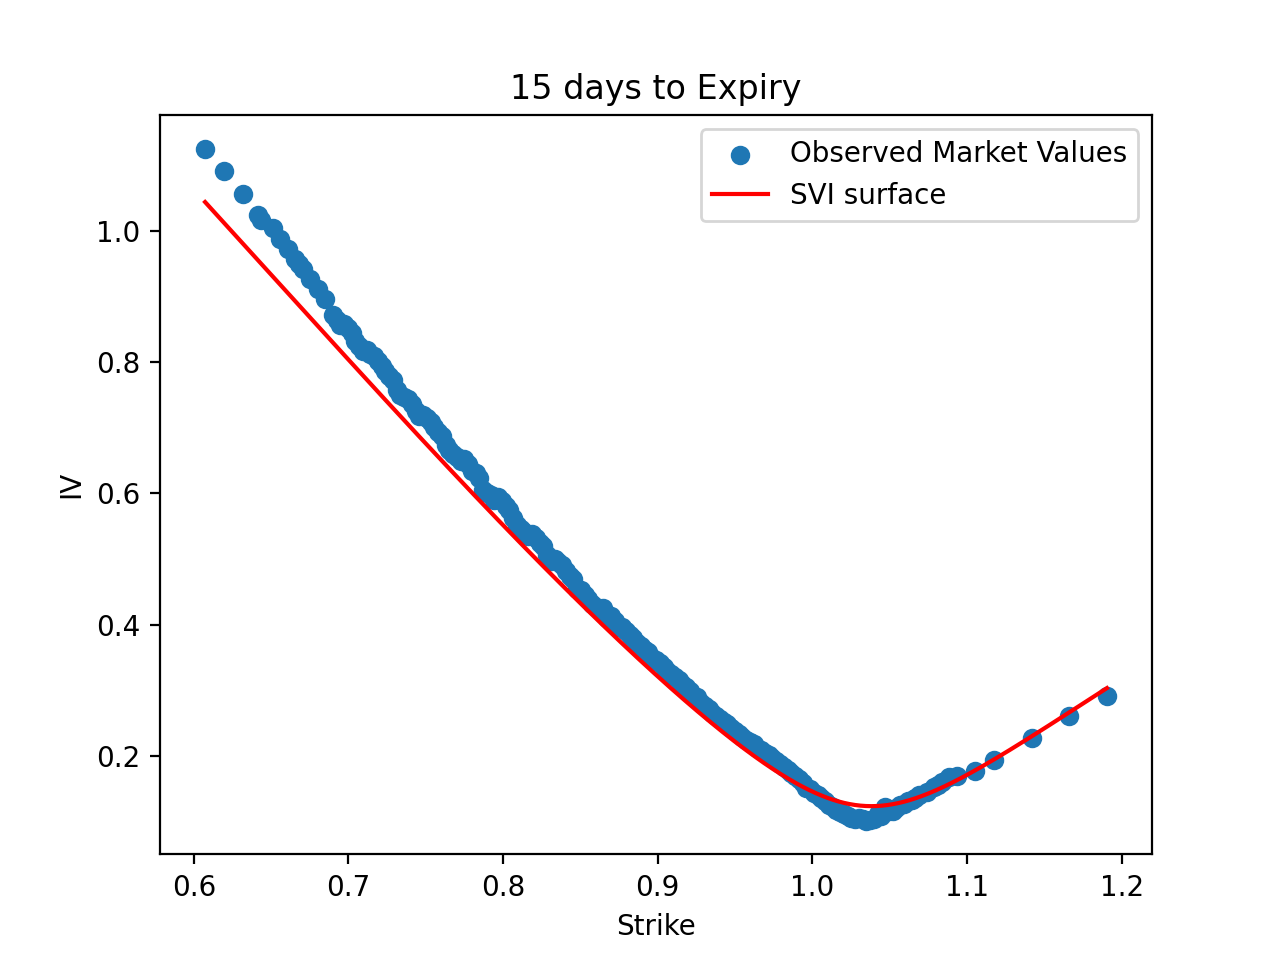

In [285]:
fig = plt.figure()
plt.scatter(testSet.moneyness, np.array(testSet.IV))
plt.plot(strikeAxis, fittedCurve, 'r-')
plt.title('15 days to Expiry')
plt.xlabel('Strike')
plt.ylabel('IV')
plt.legend(['Observed Market Values','SVI surface'])

As observed above, the volatility smirk is clear. The SVI approximates the surface well for OTM options, but slightly overestimates volatility in and around the money. As usual, the in-the-money section of the surface is sparse in data.

# Creating the Standardised IV Surface 

This IV surface will be standardised at set time to expiry and (normalised) strike prices.

In [286]:
dateIndex = allData.index.unique() 
numDTE = 21
numStrike = 21
dteGrid = np.linspace(15,90, numDTE)
strikeGrid = np.linspace(0.6, 1.2, numStrike)

In [287]:
fullSurface = pd.DataFrame(np.zeros((numDates * numStrike * numDTE, 4)), columns = ['strike', 'daysExp', 'fittedIV','Date'])
dteCol, strikeCol = pd.core.reshape.util.cartesian_product([dteGrid, strikeGrid])

for i in range(numDates):
    newSurface = pd.DataFrame(dict(strike = strikeCol, daysExp = dteCol))
    sviInput = np.stack([dteCol, strikeCol])
    [a, b, m, rho, sig] = SVIparameters[i,:]
    newSurface['fittedIV'] = SVI_raw(sviInput, a, b, m, rho, sig)
    newSurface['Date'] = dateIndex[i]
    fullSurface.iloc[i*numStrike*numDTE:numStrike*numDTE * (i+1),:] = newSurface

fullSurface = fullSurface.set_index('Date')
fullSurface = fullSurface.drop(fullSurface[fullSurface.fittedIV.isna()].index.unique())
fullSurface.to_pickle('testSurface.pkl')

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_832/2237021022.py:7: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)


<IPython.core.display.Javascript object>


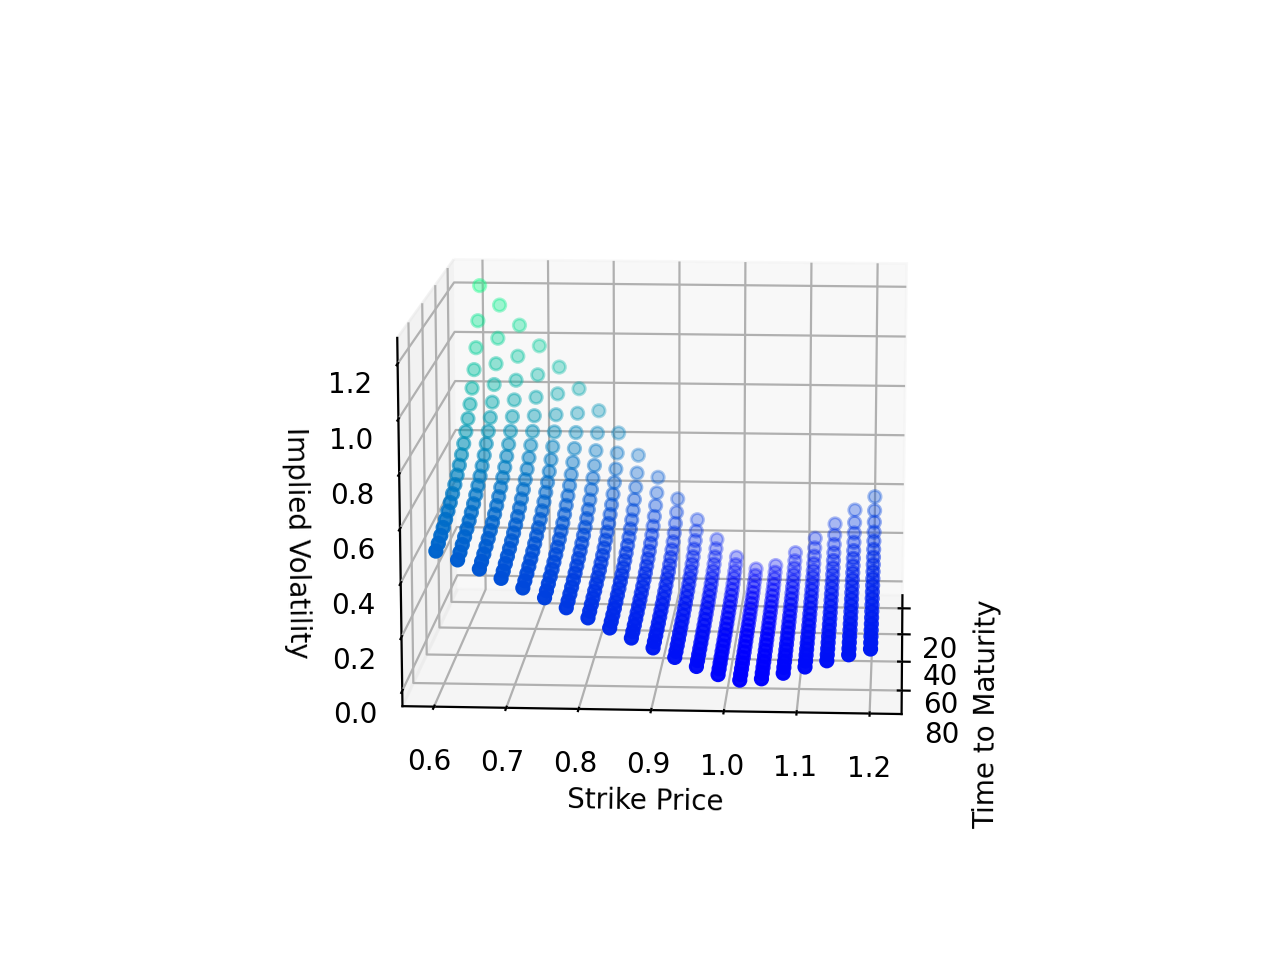

Text(0.5, 0, 'Implied Volatility')

In [346]:
%matplotlib notebook
fig = plt.figure('IV Surface')
ax = fig.add_subplot(projection='3d')

ax.scatter(newSurface.daysExp, newSurface.strike, newSurface.fittedIV, cmap = 'winter', c = newSurface.fittedIV)
ax.set_xlabel('Time to Maturity')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Implied Volatility')

The above is the parameterised Implied Volatility Surface.